# 1. Set up environment

In [ ]:
import os
from pathlib import Path

from shapely import LineString
import pandas as pd
import geopandas as gpd

import contextily as ctx
import folium

import matplotlib.pyplot as plt
import city2graph

# Configure matplotlib for better visualizations
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['figure.dpi'] = 100
plt.style.use('ggplot')

# 2. Load GTFS Data

The General Transit Feed Specification (GTFS) is a standard format for public transportation schedules and associated geographic information. In this example, we employ a GTFS of London from [Transport for London](https://tfl.gov.uk/info-for/open-data-users/our-open-data). For more information about the data structure, please refer to [the official documentation of GTFS](https://gtfs.org/documentation/overview/).

In [3]:
sample_gtfs_path = Path("./itm_london_gtfs.zip")
gtfs_data = city2graph.load_gtfs(sample_gtfs_path)

INFO:city2graph.transportation:Loading GTFS data from itm_london_gtfs.zip...
INFO:city2graph.transportation:Loaded 10 GTFS files
INFO:city2graph.transportation:Processing GTFS DataFrames...
INFO:city2graph.transportation:Creating stops geometry...
INFO:city2graph.transportation:Creating shapes geometry...
INFO:city2graph.transportation:GTFS data processing complete


GTFS contains the necessary information for the schedule of public transportation, such as the calendar, trip, route, and stop times. `load_gtfs` provides a dictionary of such tabular data in `pd.DataFrame` or `gpd.GeoDataFrame` with coordinates.

In [4]:
gtfs_data.keys()

dict_keys(['agency', 'calendar', 'calendar_dates', 'feed_info', 'frequencies', 'routes', 'shapes', 'stop_times', 'stops', 'trips'])

In [5]:
gtfs_data['agency'].head()

,agency_id,agency_name,agency_url,agency_timezone,agency_lang,agency_phone,agency_noc
0,OP5051,FlixBus,https://www.traveline.info,Europe/London,EN,NaN,FLIX
1,OP564,Megabus,https://www.traveline.info,Europe/London,EN,NaN,MEGA
2,OP28,"New Bharat Coaches (Southall, London)",https://www.traveline.info,Europe/London,EN,NaN,BHAT
3,OP545,Scottish Citylink,https://www.traveline.info,Europe/London,EN,NaN,SCLK
4,OP13994,Barnett's Tiger Line,https://www.traveline.info,Europe/London,EN,NaN,BARC


In [6]:
gtfs_data['calendar'].head()

,service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
0,45,False,False,False,True,False,False,False,20250417,20250923
1,104,False,False,False,True,False,False,False,20250324,20250611
2,42,False,False,False,True,False,False,False,20250417,20250923
3,94,False,False,False,True,False,False,False,20250417,20250605
4,105,False,False,False,True,False,False,False,20250324,20250611


In [7]:
gtfs_data['calendar_dates'].head()

,service_id,date,exception_type
0,1000,20250418,2
1,1000,20250421,2
2,1000,20250505,2
3,1000,20250526,2
4,1000,20250825,2


In [8]:
gtfs_data['routes'].head()

,route_id,agency_id,route_short_name,route_long_name,route_type
0,103800,OP5051,940,NaN,200
1,112106,OP5051,XN10,NaN,200
2,114878,OP5051,002,NaN,200
3,113261,OP5051,N49,NaN,200
4,113262,OP5051,049,NaN,200


In [9]:
gtfs_data['stops'].head()

,stop_id,stop_code,stop_name,stop_lat,stop_lon,wheelchair_boarding,location_type,parent_station,platform_code,geometry
0,01000053216,bstgjpt,Bus Station (Bay 8),51.459064,-2.592986,0,NaN,NaN,NaN,POINT (-2.59299 51.45906)
1,0170SGP90689,sglawta,Coldharbour Lane,51.503525,-2.544981,0,NaN,NaN,NaN,POINT (-2.54498 51.50352)
2,0180BAA01319,bthmtwj,Bus Station (Bay 1),51.377853,-2.359460,0,0,018G0001,1,POINT (-2.35946 51.37785)
3,019000017,wsmpadp,Terminus B,51.361954,-2.909259,0,0,019G0001,NaN,POINT (-2.90926 51.36195)
4,0190NSC30144,wsmajaj,Alexandra Parade (Stop CC),51.347240,-2.975564,0,NaN,NaN,NaN,POINT (-2.97556 51.34724)


In [10]:
gtfs_data['stop_times'].head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,timepoint,stop_direction_name
0,VJ499f13f50ffa86ecba4c582cde0e97cf30b99b62,10:20:00,10:20:00,5810WDB48070,0,NaN,0,1,NaN,1,NaN
1,VJ499f13f50ffa86ecba4c582cde0e97cf30b99b62,10:30:00,10:30:00,5820AWC50344,1,NaN,0,0,NaN,0,NaN
2,VJ499f13f50ffa86ecba4c582cde0e97cf30b99b62,10:45:00,10:50:00,5820AWK65490,2,NaN,0,0,NaN,0,NaN
3,VJ499f13f50ffa86ecba4c582cde0e97cf30b99b62,11:10:00,11:10:00,5510AWA13122,3,NaN,0,0,NaN,0,NaN
4,VJ499f13f50ffa86ecba4c582cde0e97cf30b99b62,11:40:00,11:45:00,5710WDB48422,4,NaN,0,0,NaN,0,NaN


In [11]:
gtfs_data['trips'].head()

,route_id,service_id,trip_id,trip_headsign,direction_id,block_id,shape_id,wheelchair_accessible,trip_direction_name,vehicle_journey_code
0,103800,0,VJ499f13f50ffa86ecba4c582cde0e97cf30b99b62,Gatwick Airport,0,NaN,NaN,0,NaN,"J1004,J1035,J1066,J942,J973"
1,103800,1,VJc91f5543557f21e942eb8b7e29c6c198d067f0f3,Gatwick Airport,0,NaN,NaN,0,NaN,"J2094,J2110,J2126,J2142,J2158,J2174"
2,103800,1,VJc30f50c89b5fdce773c0ac97c2f282b2cb960ecf,Gatwick Airport,0,NaN,NaN,0,NaN,"J2361,J2376,J2391,J2406,J2421,J2435"
3,103800,1,VJ1f75c251e5ce08ef0e53ff5112966b4c26c083e4,Gatwick Airport,0,NaN,NaN,0,NaN,"J2940,J2947,J2954,J2961,J2968,J2975"
4,103800,1,VJ157e085e99c6b4a7732a952da3bdadf4ac679087,Gatwick Airport,0,NaN,NaN,0,NaN,"J3160,J3165,J3170,J3175,J3180,J3185"


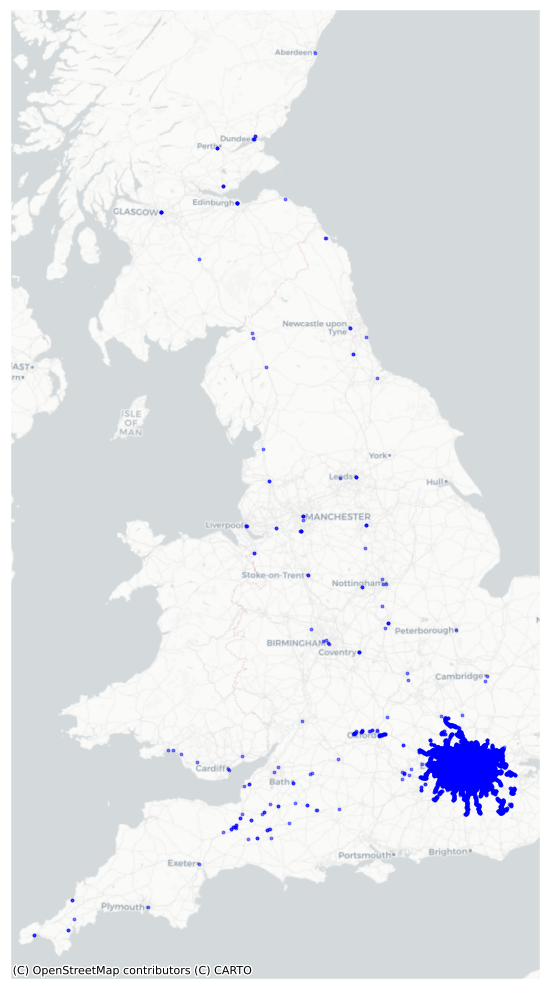

In [12]:
# Convert stops dataframe to GeoDataFrame with EPSG:4326 (WGS84) coordinates
stops_gdf = gpd.GeoDataFrame(
    gtfs_data['stops'], 
    geometry=gpd.points_from_xy(gtfs_data['stops']['stop_lon'], gtfs_data['stops']['stop_lat']),
    crs="EPSG:4326"
)

# Reproject to British National Grid (EPSG:27700)
stops_gdf_27700 = stops_gdf.to_crs(epsg=27700)

# Create the plot in British National Grid
fig, ax = plt.subplots(figsize=(12, 10))
stops_gdf_27700.plot(ax=ax, alpha=0.5, c='blue', markersize=5)  # Reduced marker size

# Add a basemap appropriate for the British National Grid
ctx.add_basemap(ax, crs=stops_gdf_27700.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Remove title and labels from coordinate axis
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

# Improve the aspect ratio for geographic data
ax.set_aspect('equal')

plt.tight_layout()

# 3. Process GTFS data to summarise the trips

After loading the GTFS, `travel_summary_network` can summarise the trips between stops. The output contains the origin and destination of stops, with average travel times in seconds and frequency in the specified time intervals.

In [ ]:
travel_summary_gdf = city2graph.travel_summary_network(
    gtfs_data, calendar_start="20250401", calendar_end="20250401", as_gdf=True
).to_crs(epsg=27700)

In [45]:
travel_summary_gdf.head()

,from_stop_id,to_stop_id,travel_time,frequency,geometry,travel_time_quantiles
0,01000053216,0170SGP90689,750.0,6,"LINESTRING (358898.043 173510.112, 362270.027 ...",3
1,01000053216,360000174,3600.0,1,"LINESTRING (358898.043 173510.112, 325333.037 ...",3
2,01000053216,490007703M,8800.0,3,"LINESTRING (358898.043 173510.112, 523267.997 ...",3
3,01000053216,490008016CS,7260.0,10,"LINESTRING (358898.043 173510.112, 507541.013 ...",3
4,01000053216,5310AWB30328,2875.0,12,"LINESTRING (358898.043 173510.112, 330886.046 ...",3


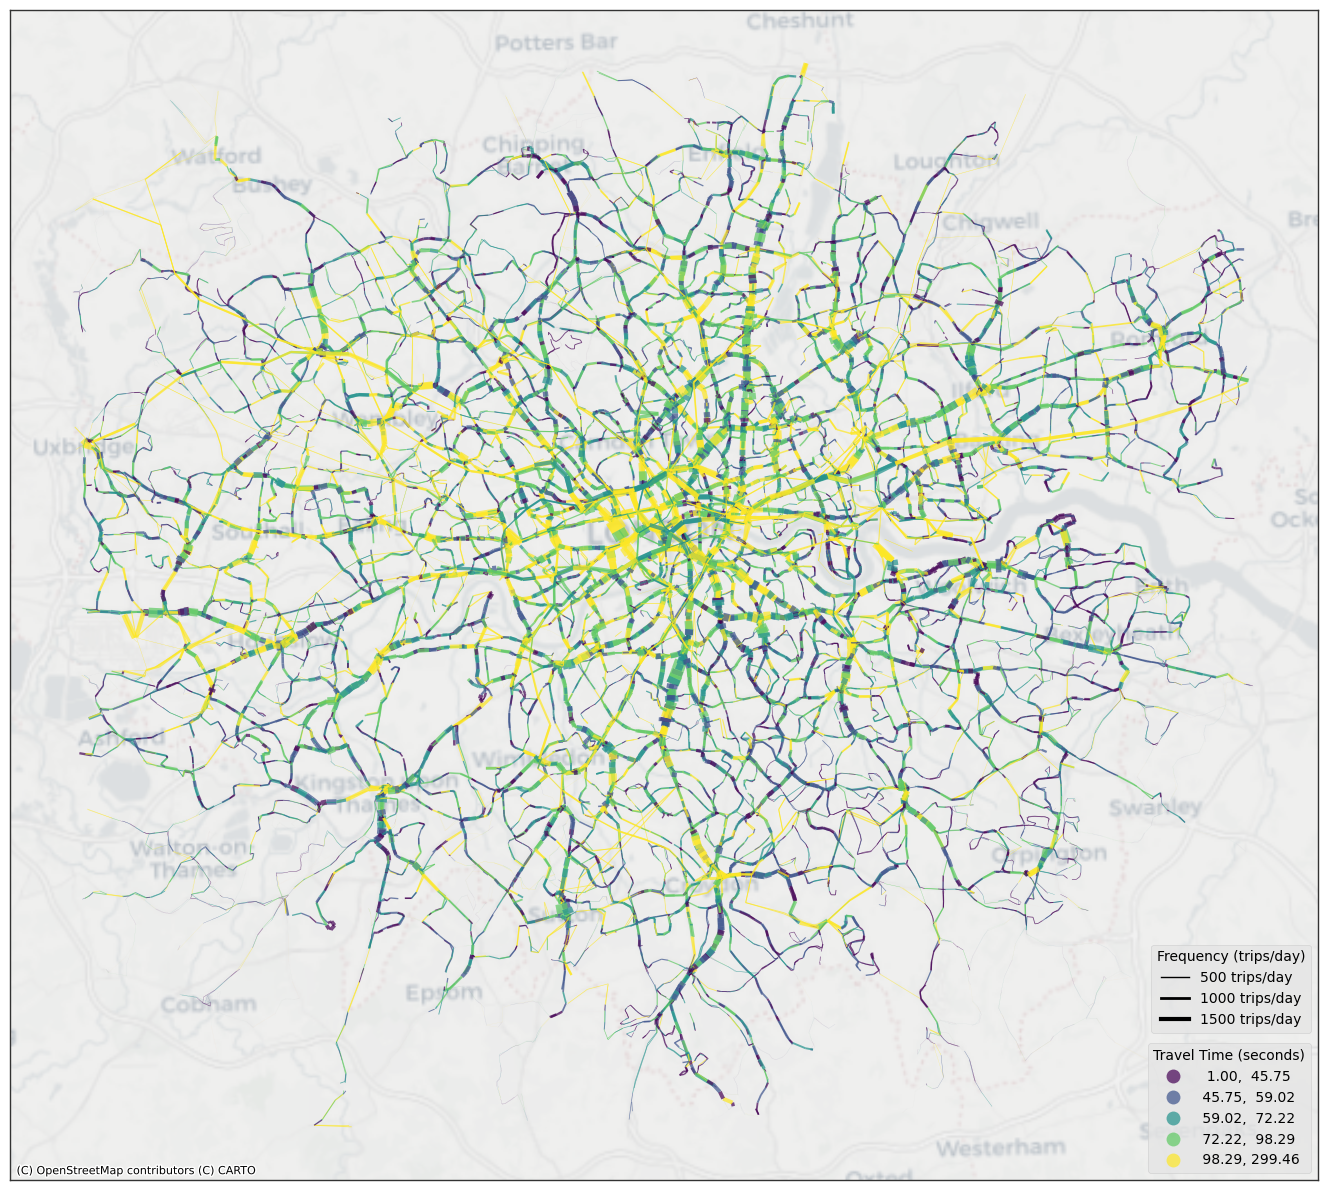

In [73]:
from shapely.geometry import box
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import geopandas as gpd
import contextily as ctx

# Define the bounding box for Greater London
london_bbox = (-0.489, 51.28, 0.236, 51.686)

# Create a box (polygon) from the bounding box
bbox = box(*london_bbox)

# Create a GeoDataFrame from the box and project to British National Grid (EPSG:27700)
bbox_gdf = gpd.GeoDataFrame({"geometry": [bbox]}, crs="EPSG:4326").to_crs(epsg=27700)

# Perform the spatial join (filtering travel times under 300 seconds)
travel_summary_gdf_cropped = gpd.sjoin(
    travel_summary_gdf[travel_summary_gdf["travel_time"] < 300],
    bbox_gdf,
    how="inner",
    predicate="within"
)

# Create a visually appealing color map
cmap = plt.cm.viridis

# Create a larger figure and axis for visualization
fig, ax = plt.subplots(figsize=(15, 12))

# Plot the data with styling based on travel_time and frequency.
# The auto-generated legend for travel time is set to 'lower right'
travel_summary_gdf_cropped.plot(
    column="travel_time", 
    cmap=cmap,
    scheme="quantiles", 
    k=5, 
    linewidth=travel_summary_gdf_cropped['frequency'] / 500,  # Scale line width by frequency
    alpha=0.7,
    ax=ax, 
    legend=True,
    legend_kwds={'title': 'Travel Time (seconds)', 'loc': 'lower right'}
)

# Capture the auto-generated travel time legend
travel_time_legend = ax.get_legend()

# Reposition the travel time legend to the lower-right corner with explicit bbox coordinates.
# Its lower-right corner is anchored at (1, 0)
travel_time_legend.set_bbox_to_anchor((1, 0))
travel_time_legend.set_loc('lower right')

# Create custom legend handles for frequency values
freq_values = [500, 1000, 1500]
freq_legend_elements = []
for freq in freq_values:
    freq_legend_elements.append(
        mlines.Line2D([0], [0],
                      color='black',
                      linewidth=freq/500,
                      label=f'{freq} trips/day')
    )

# Add the frequency legend to the plot
freq_legend = ax.legend(
    handles=freq_legend_elements,
    title="Frequency (trips/day)",
    loc="lower right",
    bbox_to_anchor=(1, 0.12),
    frameon=True,
    framealpha=0.8
)

# Add the travel time legend back so that both legends are visible.
ax.add_artist(travel_time_legend)

# Add a basemap appropriate for the British National Grid.
ctx.add_basemap(
    ax,
    crs=travel_summary_gdf_cropped.crs.to_string(),
    source=ctx.providers.CartoDB.Positron,
    alpha=0.5
)

# Remove axis labels and ticks for a cleaner look.
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

# Add a border around the plot.
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_color('#333333')

# Ensure the aspect ratio is equal (important for geographic data).
ax.set_aspect("equal")

plt.tight_layout()
plt.show()


# 4. Create row OD matrix from GTFS (experimental)

You can create row OD matrix from GTFS data by `get_od_pairs`. However, the data amount will be explosive if the original GTFS covers broadly in terms of space and time.

In [ ]:
od_gdf = city2graph.get_od_pairs(gtfs_data, start_date="20250401", end_date="20250401", include_geometry=True, as_generator=False)

In [ ]:
# To iterate over chunks and process/write them immediately
for od_chunk in city2graph.get_od_pairs(gtfs_data, as_generator=True, chunk_size=5000):
    # Process or write the chunk to disk
    print(od_chunk.shape)
    # Optionally, write to a file in append mode:
    od_chunk.to_csv('gtfs_od_pairs_chunk.csv', mode='a', header=not os.path.exists('gtfs_od_pairs_chunk.csv'), index=False)